In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from VAN_new import *

In [10]:
taille=20

In [9]:
y1= torch.tensor([[1.0 for i in range(taille//2)] + [0.0 for i in range(taille//2)]])
y2= torch.tensor([[0.0 for i in range(taille//2)] + [1.0 for i in range(taille//2)]])
y3=torch.tensor([[0.0 for i in range(taille)]])
y4=torch.tensor([[1.0 for i in range(taille)]])
y5=torch.tensor([[1.0, 0.0] *( taille//2)])

In [6]:
def log_prob_target(spins):
    ''''
    Compute the log probability of the target distribution
    spin confirgurations mostly up more likely (* 0.8) than mostly down (* 0.2)
    '''
    spin_size = spins.shape[1]
    log_probs = torch.ones(spins.shape[0]) * np.log(0.2)
    log_probs[spins.mean(-1) > 0.5] = np.log(0.8)
    return log_probs - np.log(2 ** (spin_size -1)) 

In [38]:


def log_prob_target_2(spins):
    """
    log proba de la target distribution. High probability if the forst spin is 1 and low otherwise
    """
    spin_size = spins.shape[1]
    log_probs = torch.ones(spins.shape[0]) * np.log(0.2)
    
    log_probs[torch.tensor([spins[i][0] > 0.5 for i in range(len(spins))] )] = np.log(0.8)
    
    return log_probs - np.log(2 ** (spin_size -1)) 
    


In [4]:

def energie1D(spin): 
    spin_copie=spin.clone()
    spin_copie[spin_copie==0]=-1
    spin_copie_1 = torch.roll(spin_copie, -1)
    spin_copie_2 = torch.roll(spin_copie, 1)

    
    energie=- torch.sum(spin_copie_1*spin_copie+spin_copie_2*spin_copie)
    return energie
    

def log_prob_energie(beta, energie):
    return -beta*energie


def log_prob_target_energie(spins):
    
    log_probs = torch.ones(spins.shape[0]) * np.log(0.01)
    
    for i in range(len(log_probs)):
        log_probs[i] = log_prob_energie(1, energie1D(spins[i]))
    return log_probs 

    

In [44]:
# recuperer la colonne d'une matrice
def get_column(matrix, i):
    return torch.tensor([matrix[j][i] for j in range(len(matrix))])


Epoch 0: 0.7875236868858337
Epoch 100: 0.01339478325098753
Epoch 200: 0.006592523772269487
Epoch 300: 0.008550217375159264
Epoch 400: 0.002566421404480934
Epoch 500: -0.009858539327979088
Epoch 600: -0.009630540385842323
Epoch 700: -0.019542107358574867
Epoch 800: 0.0008862128015607595
Epoch 900: -0.00752991484478116


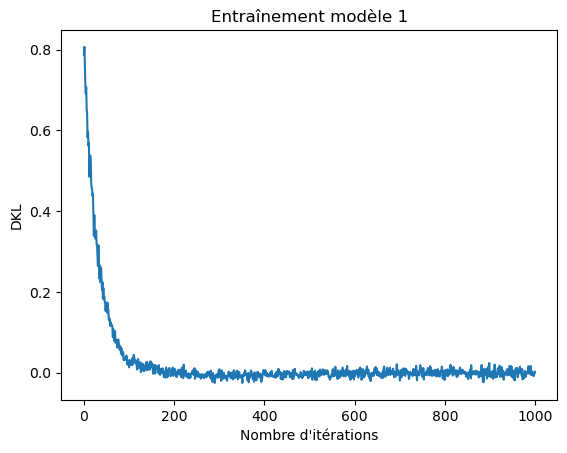

In [48]:
mymodel1 = VAN(taille)
losses = train(mymodel1, log_prob_target, batch_size=1000, n_iter=1000, lr=0.01)
plt.plot(losses)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 1')
plt.show()

In [12]:
print(mymodel1.prob_of_spins(y1))
print(mymodel1.prob_of_spins(y2))
print(mymodel1.prob_of_spins(y3))
print(mymodel1.prob_of_spins(y4))
print(mymodel1.prob_of_spins(y5))


tensor([9.0976e-07], grad_fn=<ProdBackward1>)
tensor([8.5168e-07], grad_fn=<ProdBackward1>)
tensor([3.1883e-09], grad_fn=<ProdBackward1>)
tensor([2.0146e-06], grad_fn=<ProdBackward1>)
tensor([8.8749e-07], grad_fn=<ProdBackward1>)


sur la distribution test donnée par la prof, ça marche plutôt bien

Epoch 0: 0.9554261565208435
Epoch 200: 0.6672195196151733
Epoch 400: 0.3038148880004883
Epoch 600: 0.07283208519220352
Epoch 800: 0.00235325051471591
Epoch 1000: -0.05269467458128929
Epoch 1200: -0.07197174429893494
Epoch 1400: -0.08186694979667664
Epoch 1600: -0.08155304938554764
Epoch 1800: -0.07972940802574158


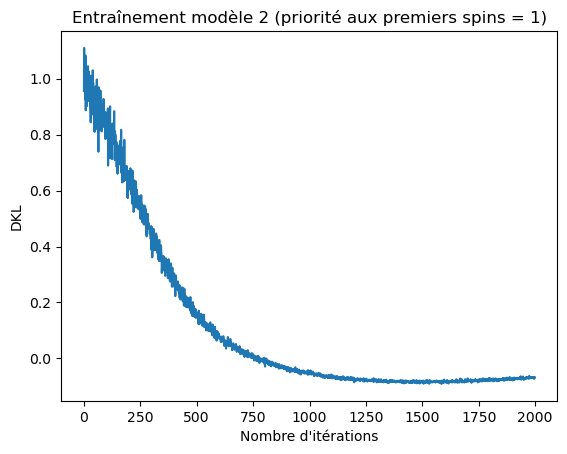

In [51]:
mymodel2 = VAN(input_size = taille)
loss=train(mymodel2, log_prob_target_2, batch_size=1000,n_iter=2000, lr=1e-3)

plt.plot(loss)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 2 (priorité aux premiers spins = 1)')
plt.show()

la loss devient négative, c'est gênant
Les prédictions sont pas trop mauvaises


In [52]:
print(mymodel2.prob_of_spins(y1))
print(mymodel2.prob_of_spins(y2))
print(mymodel2.prob_of_spins(y3))
print(mymodel2.prob_of_spins(y4))
print(mymodel2.prob_of_spins(y5))


tensor([0.0197], grad_fn=<ProdBackward1>)
tensor([0.0069], grad_fn=<ProdBackward1>)
tensor([0.0076], grad_fn=<ProdBackward1>)
tensor([0.0223], grad_fn=<ProdBackward1>)
tensor([0.0237], grad_fn=<ProdBackward1>)


<!-- entrainement pour modèle ising 1D -->

**Entrainement pour le modèle ising**


Epoch 0: 0.7647250890731812
Epoch 50: -1.5062826871871948
Epoch 100: -0.44889217615127563
Epoch 150: -0.2277282476425171
Epoch 200: -0.20790129899978638
Epoch 250: -0.022508202120661736
Epoch 300: -0.361068993806839
Epoch 350: -0.11351726204156876
Epoch 400: -0.11704988777637482
Epoch 450: -0.08888236433267593


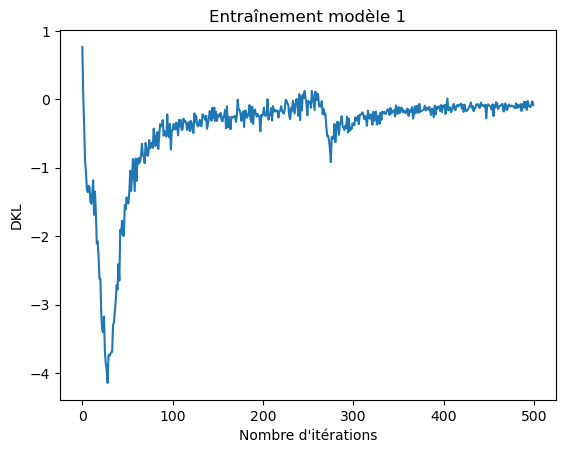

In [54]:
mymodel_ising = VAN(input_size = taille)
loss=train(mymodel_ising, log_prob_target_energie, batch_size=1000,n_iter=500, lr=1e-1)

plt.plot(loss)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 1')
plt.show()

In [36]:

y1= torch.tensor([[1.0 for i in range(taille//2)] + [0.0 for i in range(taille//2)]])
y2= torch.tensor([[0.0 for i in range(taille//2)] + [1.0 for i in range(taille//2)]])
y3=torch.tensor([[0.0 for i in range(taille)]])
y4=torch.tensor([[1.0 for i in range(taille)]])
y5=torch.tensor([[1.0, 0.0] *( taille//2)])

In [57]:
mymodel_ising.sample(100)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0